In [69]:
!which python

/Users/frederic.montet/.local/share/virtualenvs/tars-dSrcWdcW/bin/python


In [70]:
from src import TARS, markets, portfolios, traders, strategies
from src import utils
from darts import TimeSeries
from darts.models import ExponentialSmoothing
import pandas as pd

%matplotlib inline

# Predictor strategy - in development

Here's an example to show how you can develop your own strategy. This notebook is a template for you to start your own thing.

### Here's the strategy in development

It's actually a copy of the TrendFollowingMACD.

In [99]:
from src.tars.markets.crypto_market import CryptoMarket
market = CryptoMarket()

# get last frame
df = market.get_ohlc_data(pair='XETHZUSD', ascending=True, interval=15)[0]

# preprocessing
ts = TimeSeries.from_dataframe(df.reset_index(), 'dtime', 'close')

# modeling
model = ExponentialSmoothing()
model.fit(ts)

/Users/frederic.montet/.local/share/virtualenvs/tars-dSrcWdcW/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [103]:
# 3. Get the relevant informations for trading decision
prediction = model.predict(2)
current = df.iloc[-1]['close']

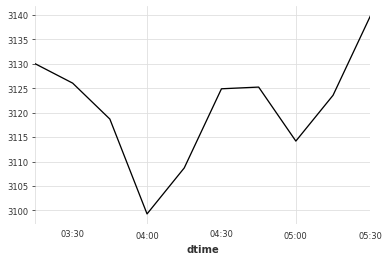

In [106]:
df[-10:]['close'].plot();

In [132]:
import pandas as pd
from src.tars.evaluators.trader_evaluator import TraderEvaluator
from src.tars.strategies.abstract_strategy import AbstractStrategy
from src.tars.markets.crypto_market import CryptoMarket


class PredictionStrategy(AbstractStrategy):
    """
    Prediction Strategy

    :param trader: Trader
        The Trader handling a portfolio
    :param pair: str
        The pair e.g. XETHZUSD to buy and hold
    :param volume: float
        The volume of the pair's quote buy
    :param validate: boolean
        Safety Boolean to make sure not to trade real money by default

    :ivar evaluator: AbstractEvaluator
        Evaluator allows for the evaluation of a strategy
    :ivar market: AbstractMarket
        Market object to get information from
    """

    def __init__(self, trader, pair, volume, validate=True):
        self.name = 'Prediction'
        self.trader = trader
        self.pair = pair
        self.volume = volume
        self.validate = validate
        self.evaluator = TraderEvaluator(self.trader)
        self.market = CryptoMarket()    

    def run(self):
        """ Run the strategy """
        # 1. Add a checkpoint to the evaluator
        balance = self.trader.portfolio.get_trade_balance().loc['eb'].ZUSD   
        self.evaluator.add_checkpoint(pd.Timestamp.utcnow(), balance)
        
        # 2. Process the data
        market = CryptoMarket()

        # get last frame
        df = market.get_ohlc_data(pair=self.pair, ascending=True, interval=15)[0]

        # preprocessing
        ts = TimeSeries.from_dataframe(df.reset_index(), 'dtime', 'close')

        # modeling
        model = ExponentialSmoothing()
        model.fit(ts)

        # 3. Get the relevant informations for trading decision
        prediction = round(model.predict(2).last_value(),2)
        current = df.iloc[-1]['close']

        # 4. Implement the trading logic
        if prediction < current:
            self.trader.add_order(pair=self.pair, type='sell',
                                  ordertype='market', volume=self.volume,
                                  validate=self.validate)

        elif prediction >= current:
            self.trader.add_order(pair=self.pair, type='buy',
                                  ordertype='market', volume=self.volume,
                                  validate=self.validate)
        else:
            pass


## Instanciate Tars

Then, it is as usual.

In [133]:
api_key = f'../kraken.key'

In [134]:
portfolio_1 = portfolios.VirtualPortfolio({'ZUSD': 1000})
trader_1 = traders.VirtualCryptoTrader(portfolio_1)
strategy_1 = strategies.BuyAndHold(trader_1, 'XETHZUSD', 0.2)

portfolio_2 = portfolios.VirtualPortfolio({'ZUSD': 1000})
trader_2 = traders.VirtualCryptoTrader(portfolio_2)

# Here's where you use your newly developed strategy
strategy_2 = PredictionStrategy(trader_2, 'XETHZUSD', 0.2)

In [135]:
# Create Tars and load its strategies
tars = TARS()
tars.load(strategy_1)
tars.load(strategy_2)

INFO:root:🤖 TARS : Welcome to Endurance! 👨‍🚀
INFO:root:🤖 TARS : Loaded strategy ➡️ Buy and hold
INFO:root:🤖 TARS : Loaded strategy ➡️ Prediction


## Start the bot

In [136]:
tars.start('00:00:10')

INFO:root:🤖 TARS : Starting trading session 📈
INFO:root:⏱ Trading decision will be taken every : 00:00:10️ (hh:mm:ss)
INFO:root:💪️ Loading :   
INFO:root:  🧵 'Thread-6' ➡️ 'Buy and hold'
INFO:root:  🧵 'Thread-7' ➡️ 'Prediction'
/Users/frederic.montet/.local/share/virtualenvs/tars-dSrcWdcW/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


## Evaluate the strategy

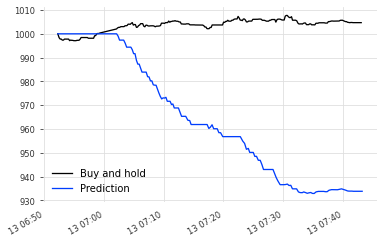

/Users/frederic.montet/.local/share/virtualenvs/tars-dSrcWdcW/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [181]:
tars.plot()

In [179]:
tars.evaluate().tail()

attempt: 001 | ['EAPI:Rate limit exceeded']


,Buy and hold,Prediction
2021-08-13 07:28:00+00:00,1006.00,943.01
2021-08-13 07:29:00+00:00,1006.17,938.30
2021-08-13 07:30:00+00:00,1005.79,936.63
2021-08-13 07:31:00+00:00,1006.83,936.36
2021-08-13 07:32:00+00:00,1005.71,934.88


/Users/frederic.montet/.local/share/virtualenvs/tars-dSrcWdcW/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


attempt: 000 | ['EAPI:Rate limit exceeded']
attempt: 001 | ['EAPI:Rate limit exceeded']
attempt: 002 | ['EAPI:Rate limit exceeded']
attempt: 003 | ['EAPI:Rate limit exceeded']
attempt: 000 | ['EAPI:Rate limit exceeded']
attempt: 000 | ['EAPI:Rate limit exceeded']
attempt: 001 | ['EAPI:Rate limit exceeded']
attempt: 000 | ['EAPI:Rate limit exceeded']
attempt: 000 | ['EAPI:Rate limit exceeded']
attempt: 001 | ['EAPI:Rate limit exceeded']
attempt: 000 | ['EAPI:Rate limit exceeded']
attempt: 001 | ['EAPI:Rate limit exceeded']
attempt: 002 | ['EAPI:Rate limit exceeded']
attempt: 000 | ['EAPI:Rate limit exceeded']
attempt: 001 | ['EAPI:Rate limit exceeded']
attempt: 000 | ['EAPI:Rate limit exceeded']
attempt: 001 | ['EAPI:Rate limit exceeded']
attempt: 002 | ['EAPI:Rate limit exceeded']
attempt: 003 | ['EAPI:Rate limit exceeded']
attempt: 004 | ['EAPI:Rate limit exceeded']
attempt: 000 | ['EAPI:Rate limit exceeded']
attempt: 001 | ['EAPI:Rate limit exceeded']
attempt: 002 | ['EAPI:Rate limit

## Stop the bot

In [182]:
tars.stop()

INFO:root:🤖 TARS : ✋ Stopped all strategies


---